In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '3' if USE_GPU else ''
EPS = 1e-15

In [3]:
import ROOT
import rootpy
import root_numpy
import uproot

/opt/conda/anaconda3/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


## Detector

![title](img/juno.png)

![title](img/juno2.png)

More:
http://juno.ihep.cas.cn/ATEjuno/201309/t20130912_109433.html

## Data description

lpmt — большие ФЭУ, spmt — маленькие,
hits — зарегистрированные фото-электроны (не все фотоны выбивают фото-электрон, и не всякий фото-электрон регистрируется)
Каждый hit имеет 3 характеристики: номер ФЭУ (pmtID), время от физического события в детекторе (hitTime) и происхождение (isDN=0 для нормальных хитов, isDN=1 для шума в самих ФЭУ).

В каждом физическом событии может быть переменное количество хитов. Количество хитов сохранено в переменной nHits. Технически nHits — это длина массивов pmtID, hitTime и isDN в каждом событии.

В true_info записаны данные, которые нельзя напрямую измерить, но можно предсказывать: E — энергия в МэВ; x,y,z,R — координаты в мм (R^2 = x^2+y^2+z^2). События в деревьях соответствуют друг другу по порядковому номеру: певрое из true_info соответствует первому из lpmt_hits и первому из spmt_hits.

lpmt_pos и spmt_pos — это координаты ФЭУ (x, y, z в миллиметрах).

## Goals

* Классификация шумовых событий и реальных, т.к. ФЭУ могут срабатывать случайно
* Восстановление энергии или положения

## Exploratory Data Analysis

In [4]:
lpmt_hits = pd.read_hdf('../data/lpmt_hits.h5', mode='r') 
lpmt_hits.shape

(929768817, 4)

In [5]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,0,249.992615,False,14175
1,0,40.010311,False,17319
2,0,162.123199,False,16882
3,0,51.875614,False,14951
4,0,79.817497,False,10947


In [6]:
spmt_hits = pd.read_hdf('../data/spmt_hits.h5', mode='r')
spmt_hits.shape

(33958478, 4)

In [7]:
spmt_hits.head()

,event,hitTime,isDN,pmtID
0,0,37.040001,False,318069
1,0,238.278091,False,311819
2,0,103.316055,False,307244
3,0,108.034225,False,323230
4,0,36.505154,False,320568


In [8]:
true_info = pd.read_csv('true_info.csv') 
true_info.shape

(100000, 6)

In [9]:
true_info.head()

,E,R,evtID,x,y,z
0,4.747791,14610.378,0,8290.7790,11995.6180,911.74286
1,3.919721,14630.141,1,11397.6320,5407.4497,-7409.08200
2,6.823932,14573.132,2,14063.3380,-3812.8540,246.65280
3,3.765940,16820.080,3,-2377.9307,-16317.7020,3315.59030
4,3.217473,13026.938,4,-8617.1170,868.5116,9730.98600


In [10]:
lpmt_pos = pd.read_csv('lpmt_pos.csv') 
lpmt_pos.shape

(17739, 4)

In [11]:
lpmt_pos.head()

,pmt_id,pmt_x,pmt_y,pmt_z
0,0,1.049021e+03,0.0000,19171.32
1,1,9.084785e+02,524.5103,19171.32
2,2,5.245103e+02,908.4785,19171.32
3,3,6.423399e-14,1049.0206,19171.32
4,4,-5.245103e+02,908.4785,19171.32


In [12]:
spmt_pos = pd.read_csv('spmt_pos.csv') 
spmt_pos.shape

(24952, 4)

In [13]:
spmt_pos.head()

,pmt_id,pmt_x,pmt_y,pmt_z
0,300000,1.384810e+03,244.17944,19148.438
1,300001,1.217782e+03,703.08670,19148.438
2,300002,9.038709e+02,1077.19130,19148.438
3,300003,4.809396e+02,1321.37070,19148.438
4,300004,8.610328e-14,1406.17330,19148.438


In [14]:
event_id = 10000
lpmt_event_hits = lpmt_hits.loc[lpmt_hits['event'] == event_id]
spmt_event_hits = spmt_hits.loc[spmt_hits['event'] == event_id]

In [16]:
lpmt_hits_values = lpmt_event_hits['pmtID'].values
spmt_hits_values = spmt_event_hits['pmtID'].values

In [17]:
lpmt_hits_mask = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values:
        lpmt_hits_mask.append("g")
    else:
        lpmt_hits_mask.append("r")
        
spmt_hits_mask = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values:
        spmt_hits_mask.append("g")
    else:
        spmt_hits_mask.append("r")

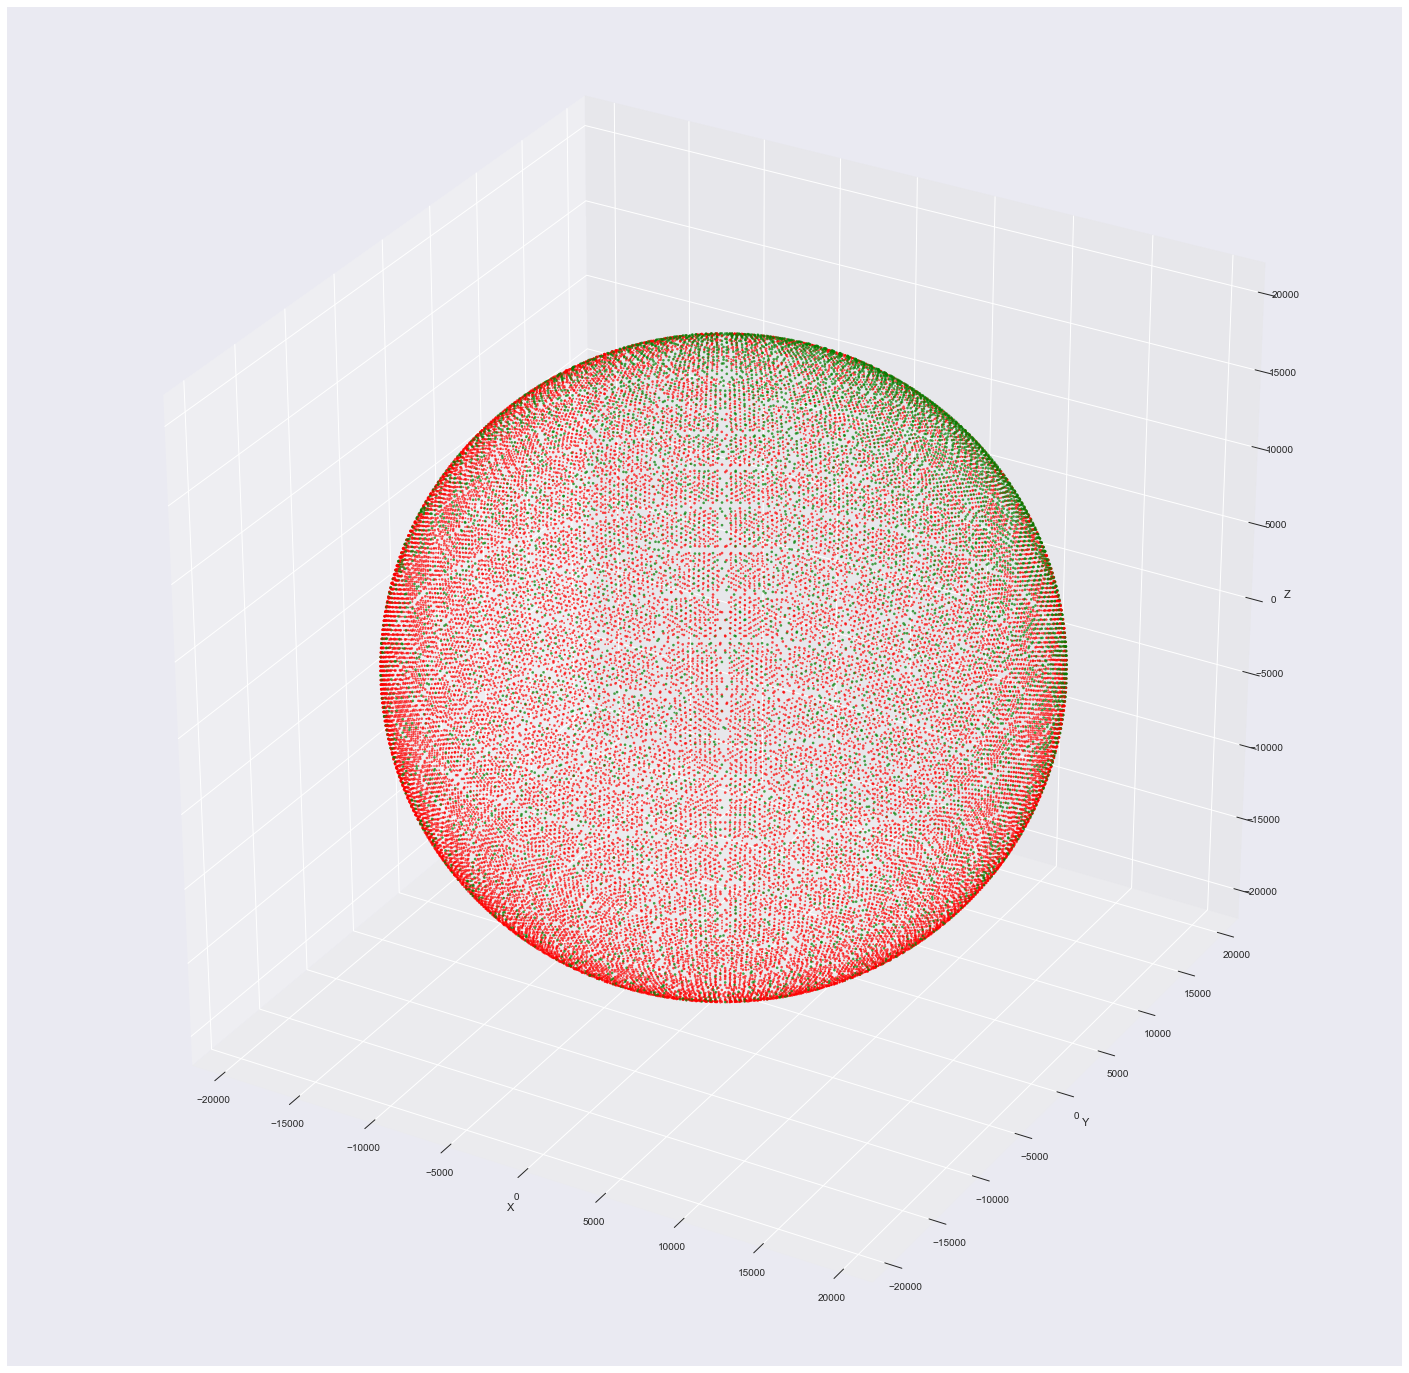

In [19]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = lpmt_pos['pmt_x']
y = lpmt_pos['pmt_y']
z = lpmt_pos['pmt_z']

ax.scatter(x, y, z, c=lpmt_hits_mask, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = spmt_pos['pmt_x']
y = spmt_pos['pmt_y']
z = spmt_pos['pmt_z']

ax.scatter(x, y, z, c=spmt_hits_mask, marker='o', s=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Signal without DN

In [20]:
lpmt_event_hits_without_DN = lpmt_event_hits.loc[lpmt_event_hits['isDN'] == False]
spmt_event_hits_without_DN = spmt_event_hits.loc[spmt_event_hits['isDN'] == False]

In [21]:
lpmt_hits_values2 = lpmt_event_hits_without_DN['pmtID'].values
spmt_hits_values2 = lpmt_event_hits_without_DN ['pmtID'].values

In [25]:
lpmt_hits_mask2 = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values2:
        lpmt_hits_mask2.append("g")
    else:
        lpmt_hits_mask2.append("r")
        
spmt_hits_mask2 = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values2:
        spmt_hit_mask2.append("g")
    else:
        spmt_hits_mask2.append("r")

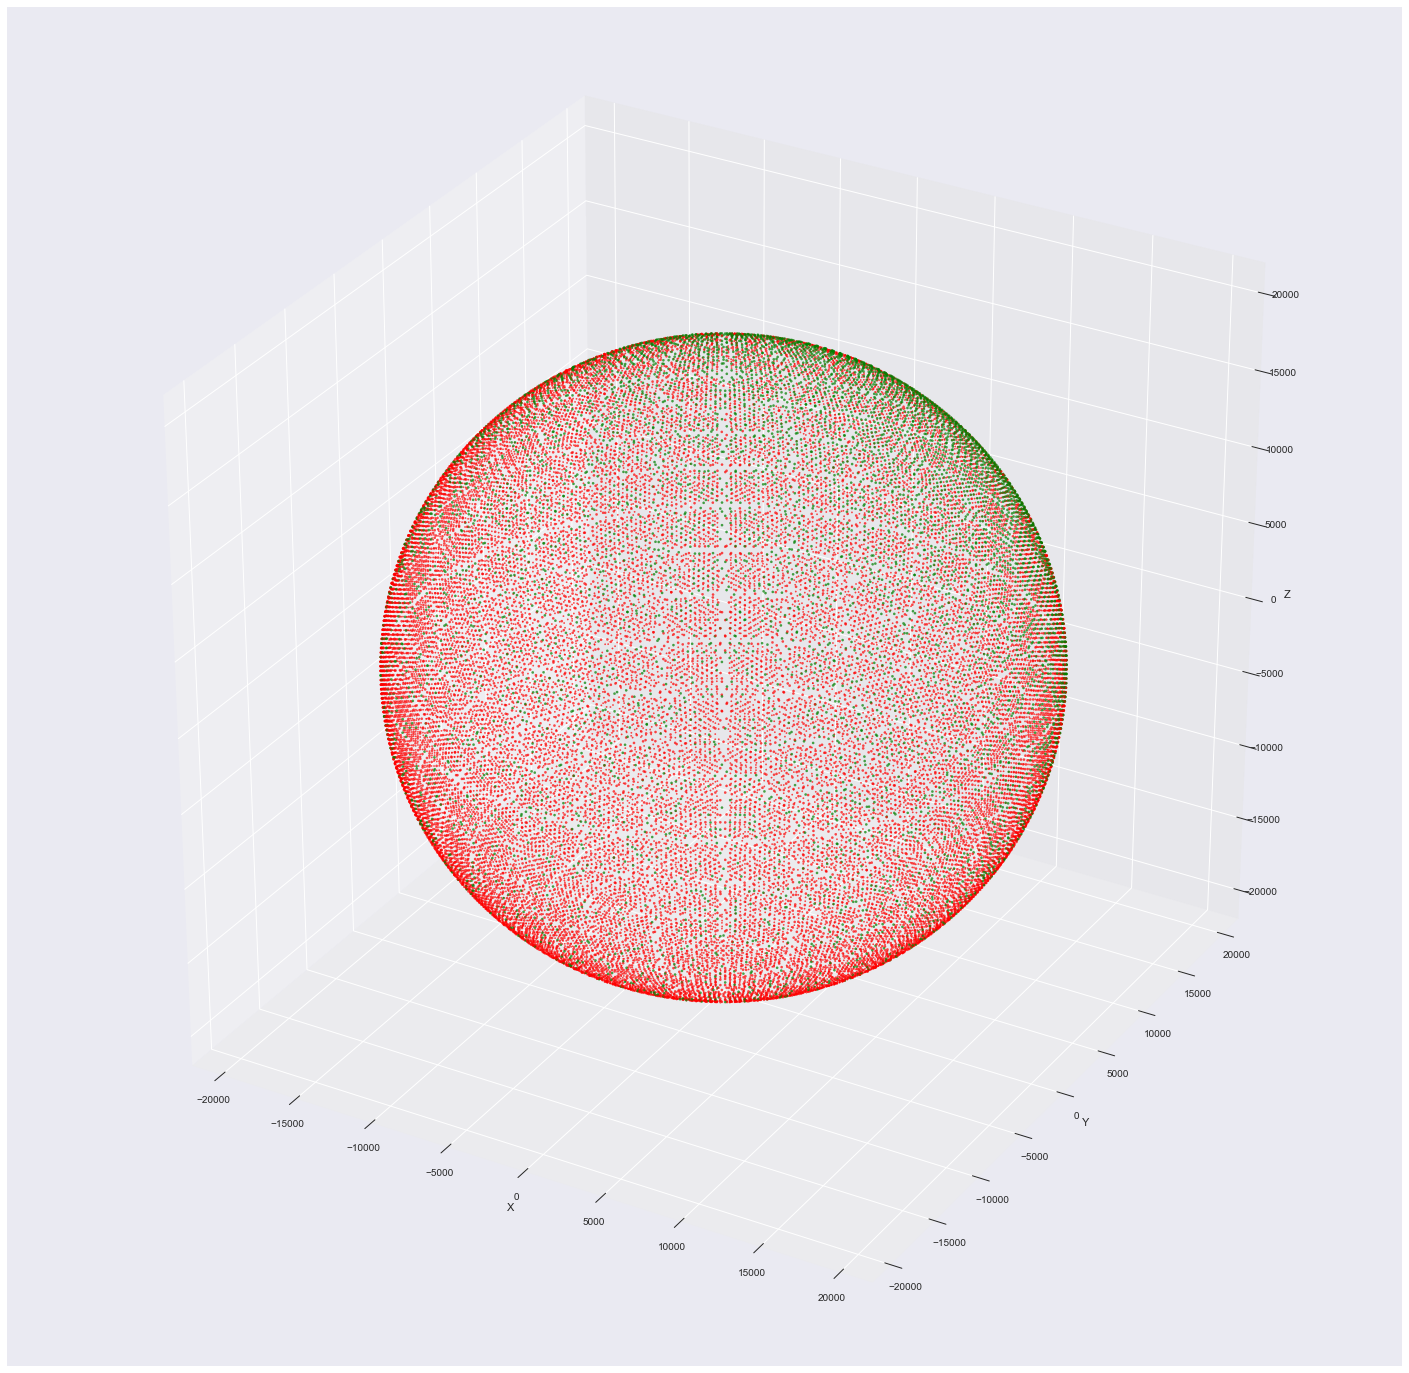

In [26]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = lpmt_pos['pmt_x']
y = lpmt_pos['pmt_y']
z = lpmt_pos['pmt_z']

ax.scatter(x, y, z, c=lpmt_hits_mask2, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = spmt_pos['pmt_x']
y = spmt_pos['pmt_y']
z = spmt_pos['pmt_z']

ax.scatter(x, y, z, c=spmt_hits_mask2, marker='o', s=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Only signal

In [33]:
lpmt_hits_mask3 = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values2:
        lpmt_hits_mask3.append("r")

spmt_hits_mask3 = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values2:
        spmt_hits_mask3.append("b")

In [37]:
lpmt_hits_values2

array([ 3276, 15176, 11805, ...,  3014,   593,  1544], dtype=int32)

In [38]:
x = []
y = []
z = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values2:
        x.append(t[2])
        y.append(t[3])
        z.append(t[4])
        
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values2:
        x.append(t[2])
        y.append(t[3])
        z.append(t[4])

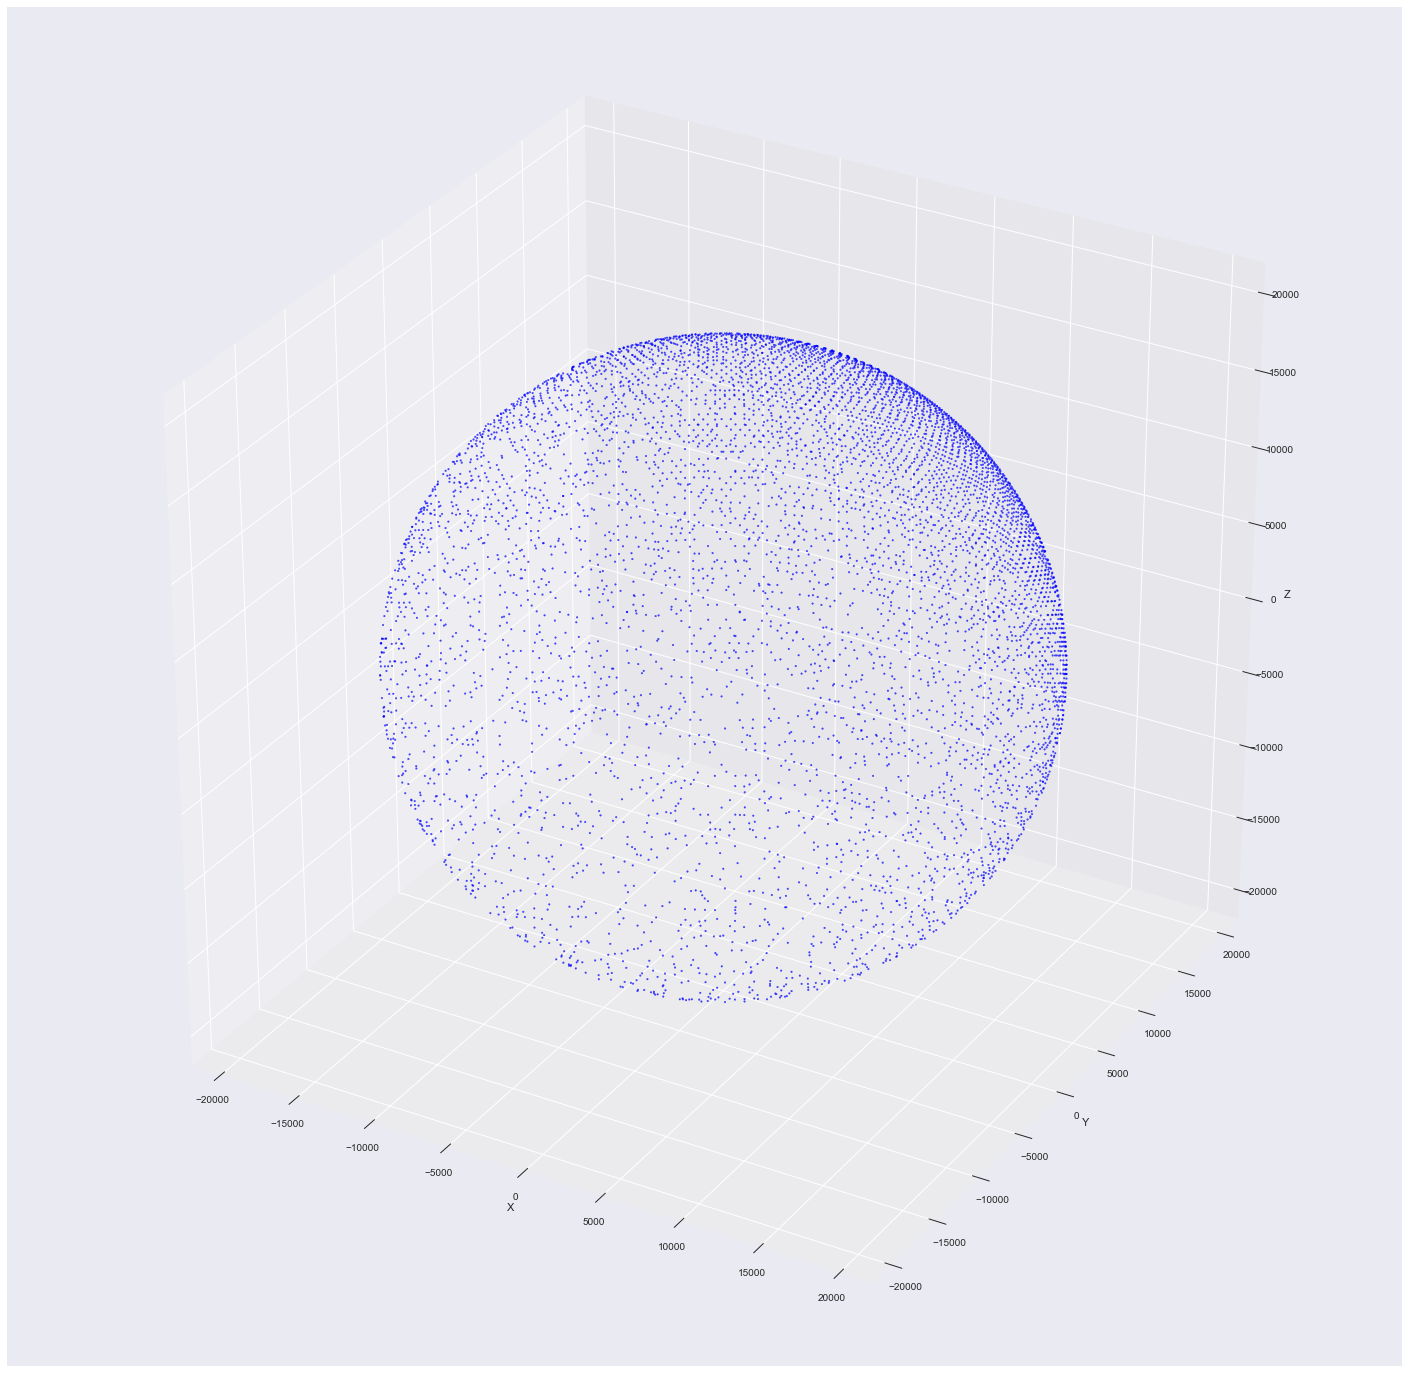

In [46]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='b', marker='o', s=3, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

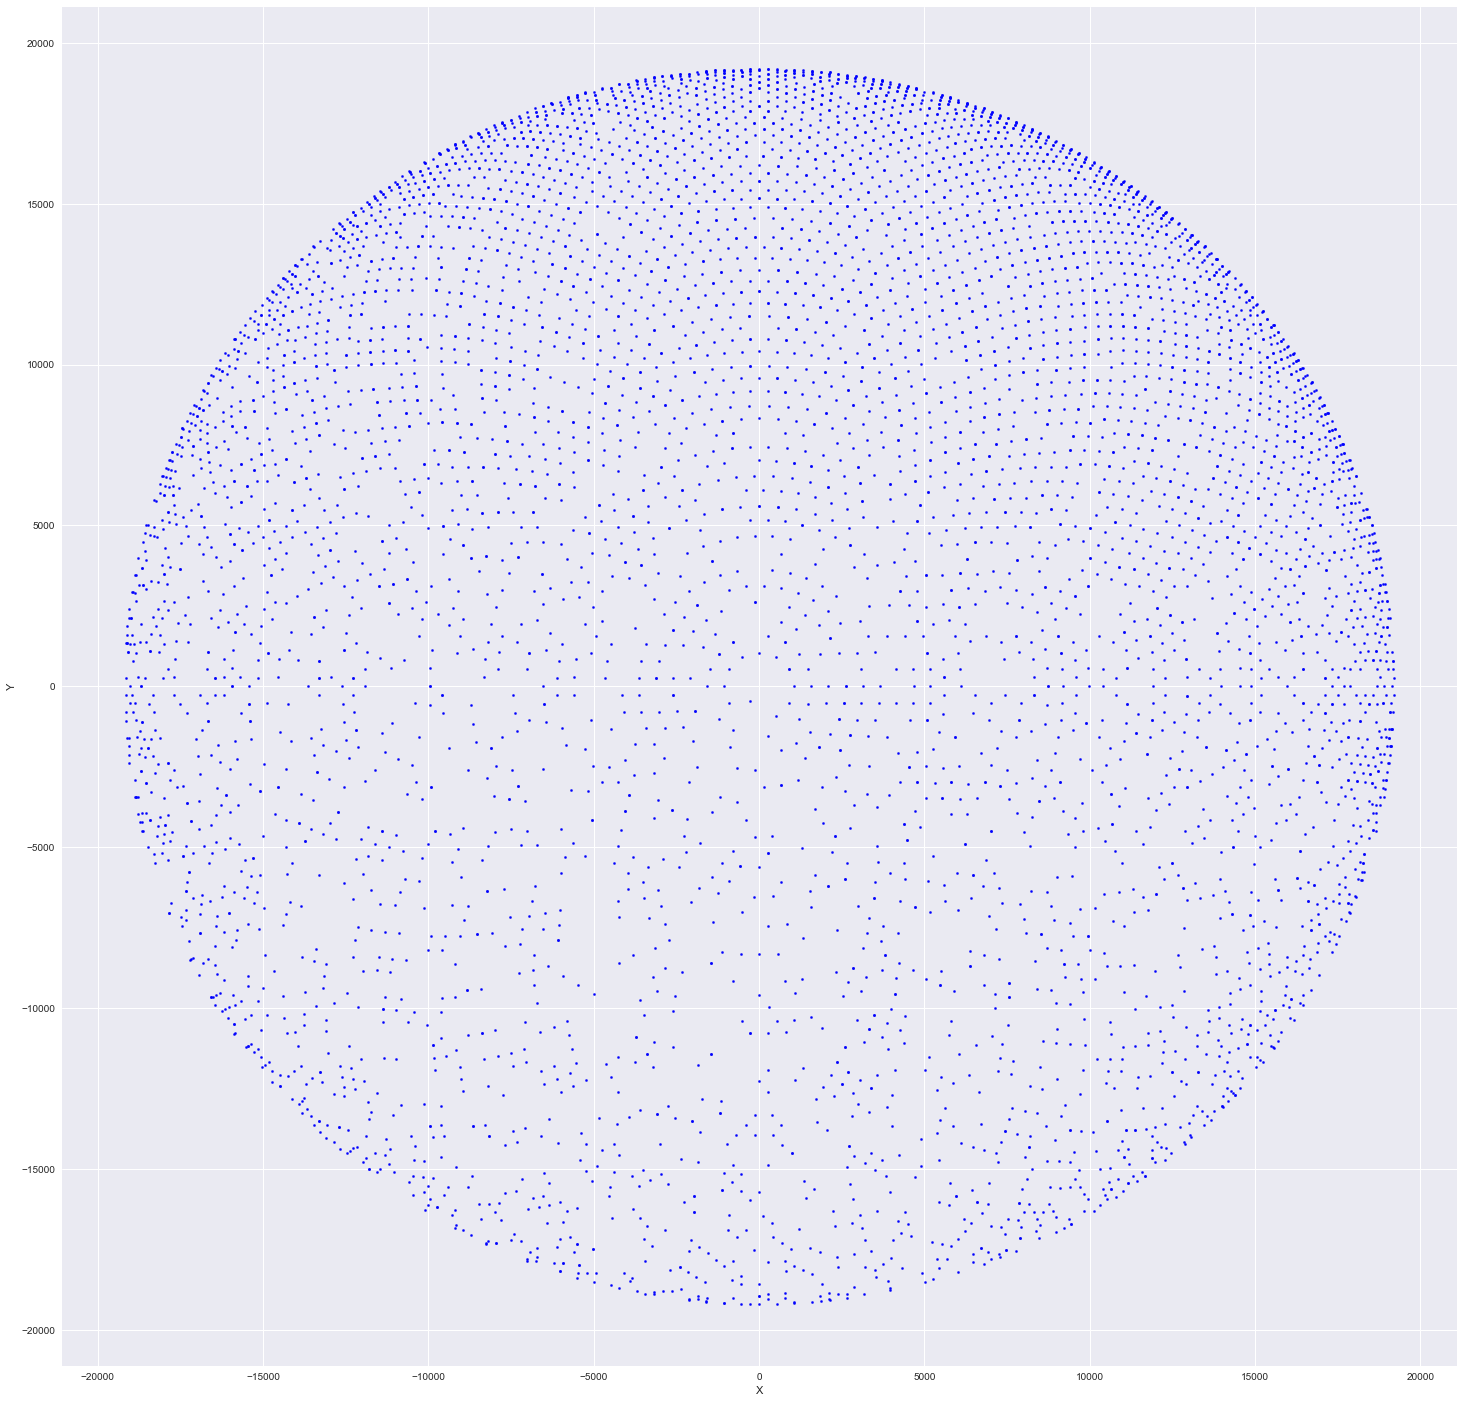

In [51]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111)

ax.scatter(x, y, c='b', marker='o', s=5, alpha=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

### Signal by time

In [52]:
lpmt_time = lpmt_event_hits['hitTime'].values

In [53]:
n = 10
lpmt_time_ints = np.linspace(min(lpmt_time), max(lpmt_time), num=n) 